# XP-EHH genome-wide selection scans

This notebook runs genome-wide selection scans.

In [1]:
%run setup.ipynb

In [2]:
for pop, config in pop_defs.items():
    print(pop, 
          len(df_haps_a.query(config['query'])))

ao_col 156
bf_col 150
bf_gam 184
ci_col 142
cm_sav_gam 192
fr_gam 48
ga_gam 138
gh_col 110
gh_gam 24
gm 130
gn_gam 80
gq_gam 18
gw 182
ke 96
ug_gam 224


In [3]:
def load_pop_haplotypes(pop, chromosome):
    
    # setup haplotypes
    if chromosome == 'X':
        loc_haps = df_haps_x.query(pop_defs[pop]['query']).index.values
        pos = callset_haps[chromosome]['variants/POS'][:]
        ht = allel.GenotypeDaskArray(callset_haps[chromosome]['calldata/GT']).to_haplotypes()
        ht_pop = da.take(ht, loc_haps, axis=1).compute()
        
    else:
        # concatenate data from both arms
        # remember, right arm goes on the left
        loc_haps = df_haps_a.query(pop_defs[pop]['query']).index.values
        arm_r = f'{chromosome}R'
        arm_l = f'{chromosome}L'
        pos_r = callset_haps[arm_r]['variants/POS'][:]
        pos_l = callset_haps[arm_l]['variants/POS'][:]
        pos = np.concatenate([pos_r, pos_l + len(genome[arm_r])])
        ht_r = allel.GenotypeDaskArray(callset_haps[arm_r]['calldata/GT']).to_haplotypes()
        ht_l = allel.GenotypeDaskArray(callset_haps[arm_l]['calldata/GT']).to_haplotypes()
        ht = da.concatenate([ht_r, ht_l], axis=0)
        ht_pop = allel.HaplotypeArray(da.take(ht, loc_haps, axis=1).compute())

    return pos, ht_pop


def load_haplotypes(pop1, pop2, chromosome, min_mac=2):
    
    # load haplotype data
    pos, ht1 = load_pop_haplotypes(pop1, chromosome)
    _, ht2 = load_pop_haplotypes(pop2, chromosome)
    
    # remove non-segregating variants
    ac1 = ht1.count_alleles(max_allele=1)
    ac2 = ht2.count_alleles(max_allele=1)
    ac = ac1 + ac2
    loc_seg = ac.min(axis=1) >= min_mac
    pos_seg = pos[loc_seg]
    ht1_seg = ht1[loc_seg]
    ht2_seg = ht2[loc_seg]
    
    # TODO load accessibility
    
    return pos_seg, ht1_seg, ht2_seg

In [5]:
def compute_xpehh(pop1, pop2, chromosome, min_ehh=0.05, max_gap=10_000, gap_scale=1_000, include_edges=True, min_mac=2):

    # run xpehh scan
    pos, ht1, ht2 = load_haplotypes(pop1, pop2, chromosome=chromosome, min_mac=min_mac)
    gpos = np.take(gmap[chromosome], pos-1)
    # TODO use accessibility
    xpehh = allel.xpehh(ht1, ht2, pos, map_pos=gpos, min_ehh=min_ehh, max_gap=max_gap,
                        gap_scale=gap_scale)

    # remove nans
    loc_nan = np.isnan(xpehh)
    pos = pos[~loc_nan]
    gpos = gpos[~loc_nan]
    xpehh = xpehh[~loc_nan]
    
    return pos, gpos, xpehh


In [6]:
xpehh_root = zarr.open(str(here() / 'data/gwss/xpehh/xpehh.zarr'))

In [40]:
def run_xpehh(pop1, pop2, chromosome, min_ehh=0.05, max_gap=10_000, gap_scale=1_000, include_edges=True, min_mac=2, window_size=500, window_step=250, markersize=1):

    # avoid running the same scan twice
    orig_pop1, orig_pop2 = pop1, pop2
    pop1, pop2 = sorted([pop1, pop2])
    
    # setup zarr group to store data
    grp_path = f'/{pop1}_{pop2}/{chromosome}'
    grp = xpehh_root.require_group(grp_path)
    complete = grp.attrs.get('complete', False)
    
    if complete:
        # previously run, load from zarr
        pos = grp['pos'][:]
        gpos = grp['gpos'][:]
        xpehh = grp['xpehh'][:]
        
    else:
        # run computation
        pos, gpos, xpehh = compute_xpehh(pop1, pop2, chromosome, min_ehh=min_ehh, max_gap=max_gap, gap_scale=gap_scale, include_edges=include_edges, min_mac=min_mac)
        grp.create_dataset('pos', data=pos, overwrite=True)
        grp.create_dataset('gpos', data=gpos, overwrite=True)
        grp.create_dataset('xpehh', data=xpehh, overwrite=True)
        grp.attrs['complete'] = True
        
    if pop1 == orig_pop2:
        # flip back
        xpehh = -xpehh
        pop1, pop2 = pop2, pop1

    # centre
    xpehh = xpehh - np.median(xpehh)
    
    # clip at zero to focus on selection in pop1
    xpehh1 = np.clip(xpehh, a_min=0, a_max=None)

    # diagnostics
    palette = sns.color_palette("Greens", 5)[1:]
    y_max = allel.moving_statistic(xpehh1, np.max, size=window_size, step=window_step)
    y_pc95 = allel.moving_statistic(xpehh1, lambda v: np.percentile(v, 95), size=window_size, step=window_step)
    y_pc75 = allel.moving_statistic(xpehh1, lambda v: np.percentile(v, 75), size=window_size, step=window_step)
    y_pc50 = allel.moving_statistic(xpehh1, np.median, size=window_size, step=window_step)

    # scale figures to chromosome size
    figwidth = pos.max()/1e7

    # plot in physical space
    x = allel.moving_statistic(pos, np.mean, size=window_size, step=window_step)
    fig, ax = plt.subplots(figsize=(figwidth, 3), facecolor='w')
    sns.despine(ax=ax, offset=3)
    ax.plot(x, y_max, marker='o', linestyle=' ', markersize=markersize, color=palette[0], label='max')
    ax.plot(x, y_pc95, marker='o', linestyle=' ', markersize=markersize, color=palette[1], label='pc95')
    ax.plot(x, y_pc75, marker='o', linestyle=' ', markersize=markersize, color=palette[2], label='pc75')
    ax.plot(x, y_pc50, marker='o', linestyle=' ', markersize=markersize, color=palette[3], label='pc50')
    lgd = ax.legend(loc='upper left')
    for handle in lgd.legendHandles:
        handle._legmarker.set_markersize(6)
    ax.set_ylabel('XP-EHH')
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks/1e6)
    ax.set_xlabel(f'Chromosome {chromosome} position (Mbp)')
    ax.set_title(f"{pop_defs[pop1]['label']} versus {pop_defs[pop2]['label']}")
    ax.set_xlim(0, pos[-1])
    ax.set_ylim(0, 6)

    # plot in genetic space
    x = allel.moving_statistic(gpos, np.mean, size=window_size, step=window_step)
    fig, ax = plt.subplots(figsize=(figwidth, 3), facecolor='w')
    sns.despine(ax=ax, offset=3)
    ax.plot(x, y_max, marker='o', linestyle=' ', markersize=markersize, color=palette[0], label='max')
    ax.plot(x, y_pc95, marker='o', linestyle=' ', markersize=markersize, color=palette[1], label='pc95')
    ax.plot(x, y_pc75, marker='o', linestyle=' ', markersize=markersize, color=palette[2], label='pc75')
    ax.plot(x, y_pc50, marker='o', linestyle=' ', markersize=markersize, color=palette[3], label='pc50')
    lgd = ax.legend(loc='upper left')
    for handle in lgd.legendHandles:
        handle._legmarker.set_markersize(6)
    ax.set_ylabel('XP-EHH')
    ax.set_xlabel(f'Chromosome {chromosome} position (cM)')
    ax.set_title(f"{pop_defs[pop1]['label']} versus {pop_defs[pop2]['label']}")
    ax.set_xlim(0, gpos[-1])
    ax.set_ylim(0, 6)
    
    plt.show()
    plt.close()


In [41]:
list(pop_defs)

['ao_col',
 'bf_col',
 'bf_gam',
 'ci_col',
 'cm_sav_gam',
 'fr_gam',
 'ga_gam',
 'gh_col',
 'gh_gam',
 'gm',
 'gn_gam',
 'gq_gam',
 'gw',
 'ke',
 'ug_gam']

In [42]:
pop_pairs = (
    # Angola An. coluzzii
    ('ao_col', 'gw'),  # comparison with neutral pop
    ('ao_col', 'bf_col'),  # geographical comparison
    # Burkina Faso An. coluzzii
    ('bf_col', 'gw'),  # comparison with neutral pop
    ('bf_col', 'ao_col'),  # geographical comparison
    ('bf_col', 'bf_gam'),  # species comparison
    # Burkina Faso An. gambiae
    ('bf_gam', 'gw'),  # comparison with neutral pop
    ('bf_gam', 'ug_gam'),  # geographical comparison
    ('bf_gam', 'bf_col'),  # species comparison
    # Cote d'Ivoire An. coluzzii
    ('ci_col', 'gw'),  # comparison with neutral pop
    ('ci_col', 'ao_col'),  # geographical comparison
    # Cameroon An. gambiae
    ('cm_sav_gam', 'gw'),  # comparison with neutral pop
    ('cm_sav_gam', 'ug_gam'),  # geographical comparison
    # Mayotte An. gambiae
    ('fr_gam', 'gw'),  # comparison with neutral pop
    ('fr_gam', 'bf_gam'),  # geographical comparison
    ('fr_gam', 'ug_gam'),  # geographical comparison
    # Gabon An. gambiae
    ('ga_gam', 'gw'),  # comparison with neutral pop
    ('ga_gam', 'bf_gam'),  # geographical comparison
    ('ga_gam', 'ug_gam'),  # geographical comparison
    # Ghana An. coluzzii
    ('gh_col', 'gw'),  # comparison with neutral pop
    ('gh_col', 'ao_col'),  # geographical comparison
    ('gh_col', 'gh_gam'),  # species comparison
    # Ghana An. gambiae
    ('gh_gam', 'gw'),  # comparison with neutral pop
    ('gh_gam', 'ug_gam'),  # geographical comparison
    ('gh_gam', 'gh_col'),  # species comparison
    # The Gambia
    ('gm', 'gq_gam'),  # comparison with neutral pop
    ('gm', 'bf_gam'),  
    ('gm', 'bf_col'),  
    # Guinea An. gambiae
    ('gn_gam', 'gw'),  # comparison with neutral pop
    ('gn_gam', 'ug_gam'),  # geographical comparison
    # Bioko An. gambiae
    ('gq_gam', 'gw'),  # comparison with neutral pop
    ('gq_gam', 'bf_gam'),  # geographical comparison
    ('gq_gam', 'ug_gam'),  # geographical comparison
    # Guinea-Bissau
    ('gw', 'gq_gam'),  # comparison with neutral pop
    ('gw', 'bf_gam'),  
    ('gw', 'bf_col'),  
    # Kenya
    ('ke', 'gw'),  # comparison with neutral pop
    ('ke', 'bf_gam'),  # geographical comparison
    # Uganda An. gambiae
    ('ug_gam', 'gw'),  # comparison with neutral pop
    ('ug_gam', 'bf_gam'),  # geographical comparison
    ('ug_gam', 'fr_gam'),  # geographical comparison
)

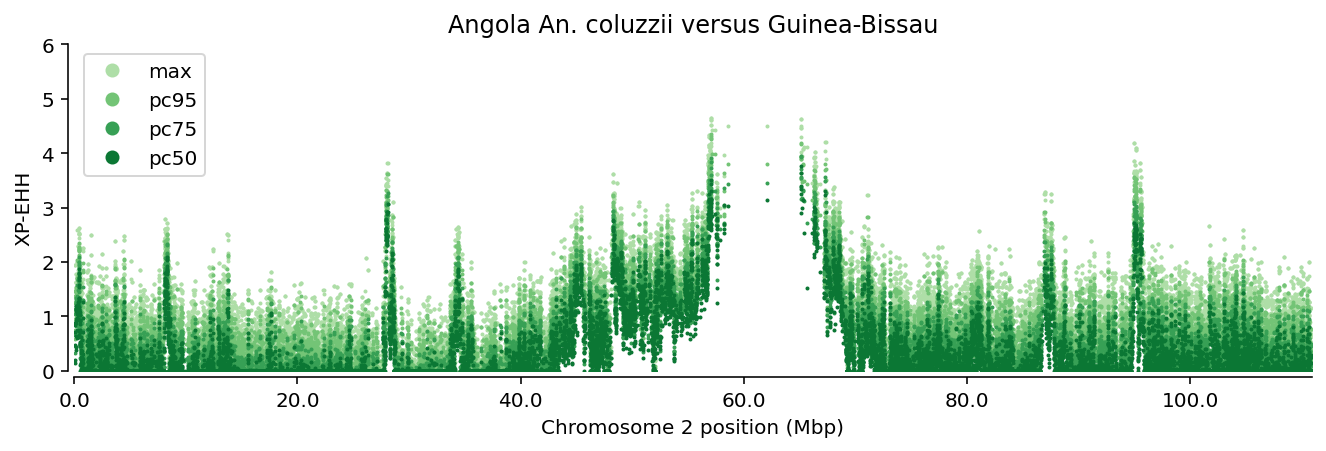

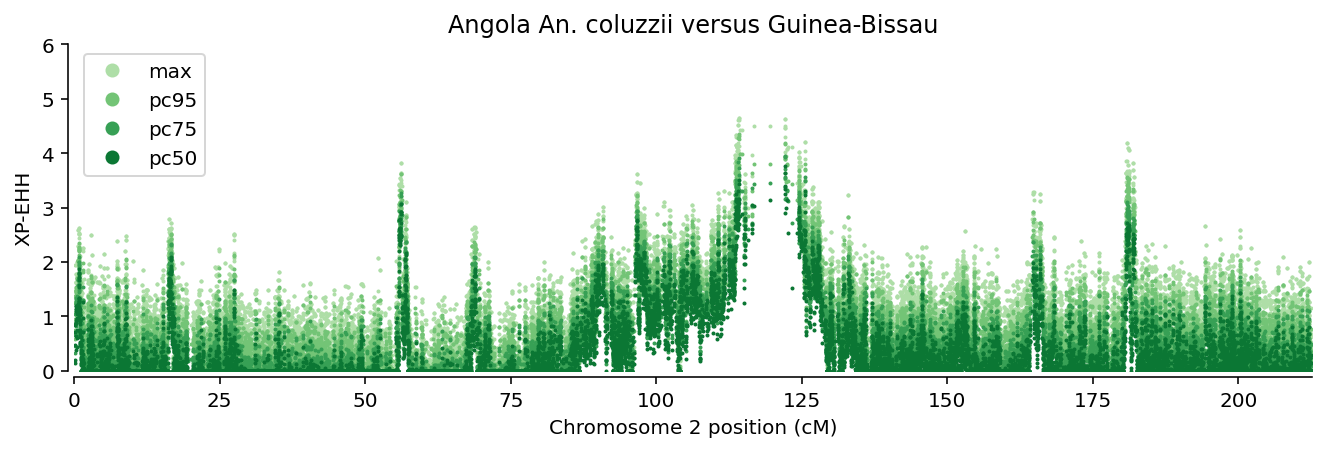

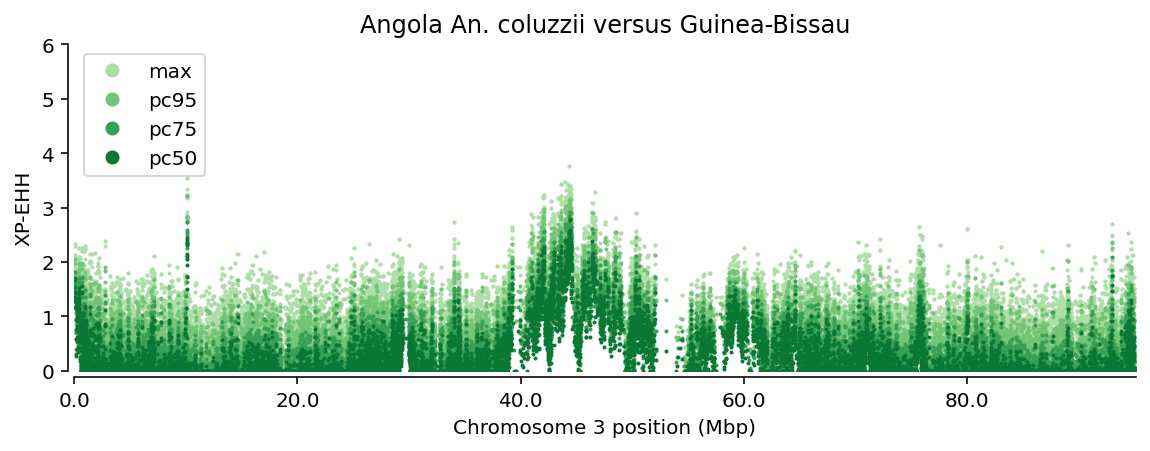

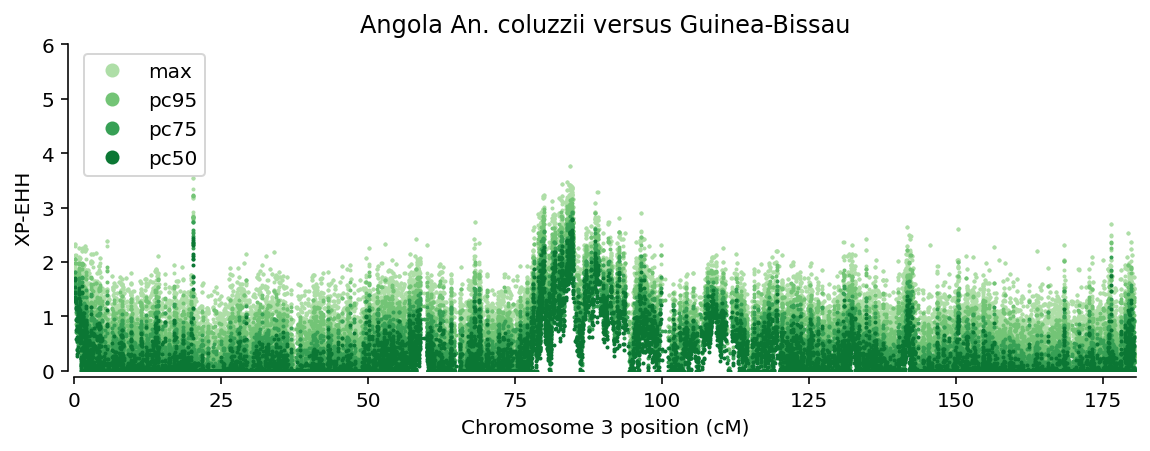

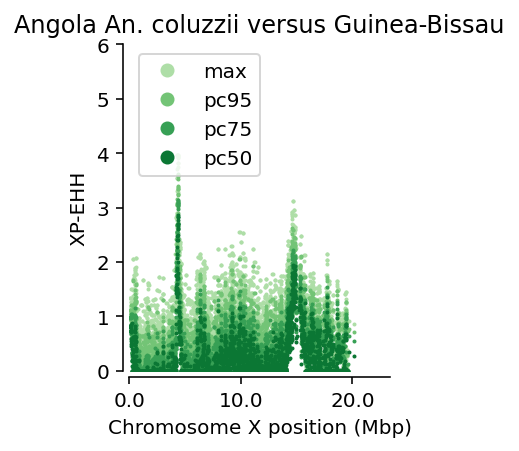

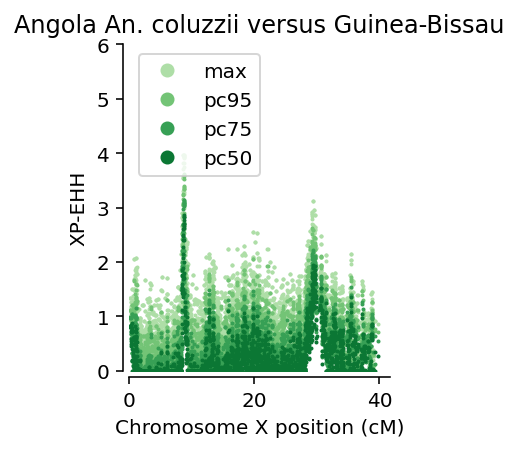

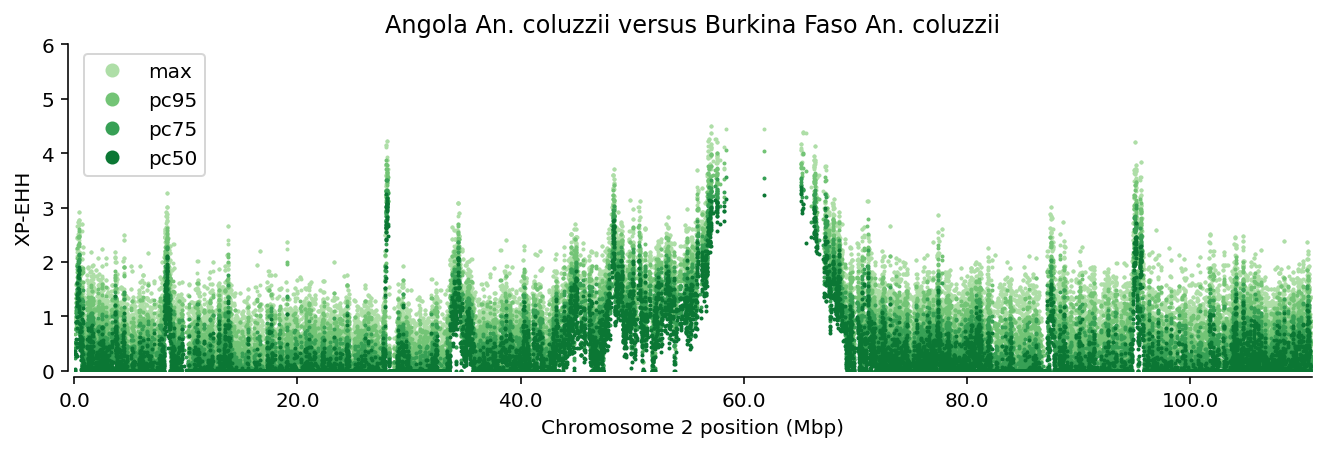

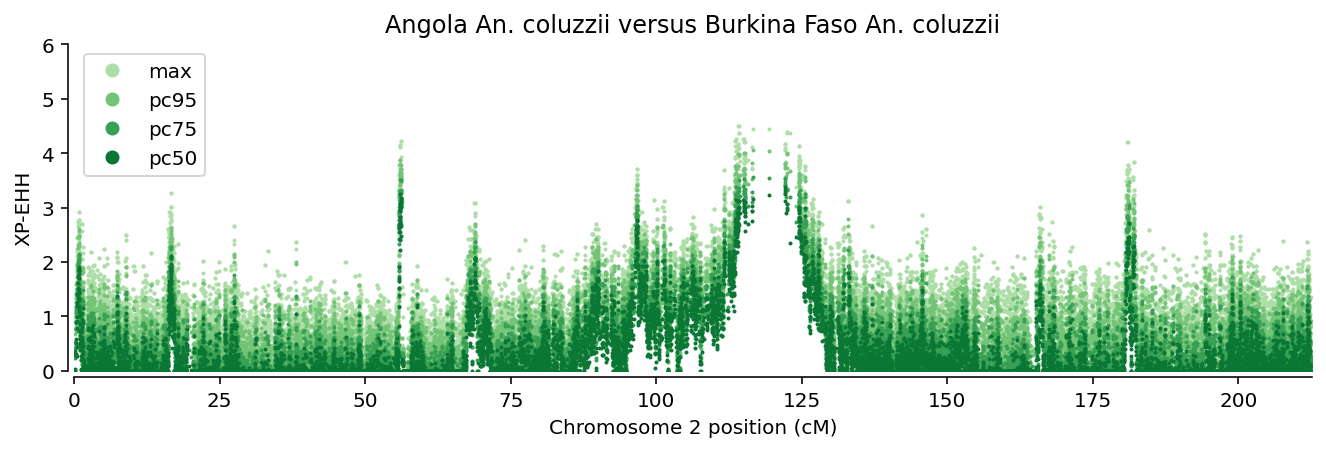

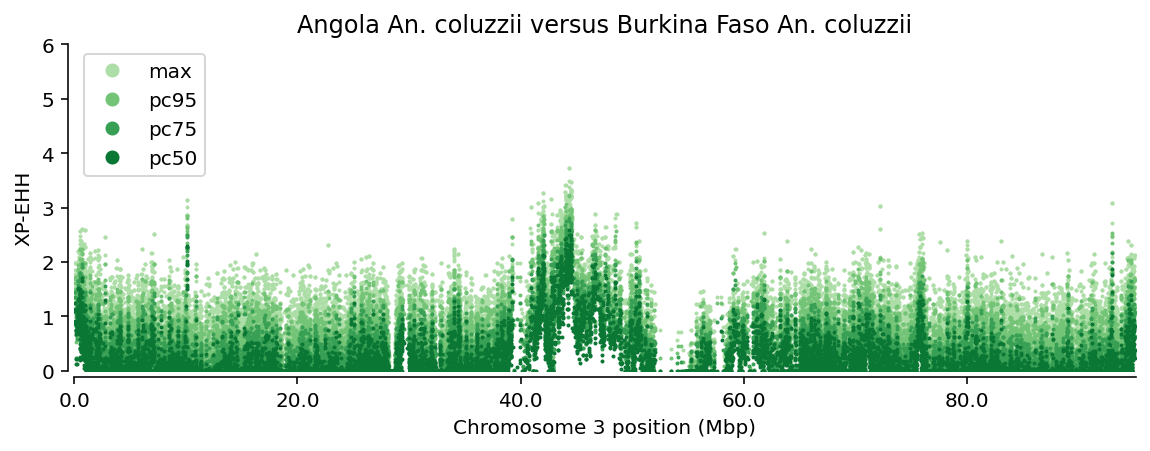

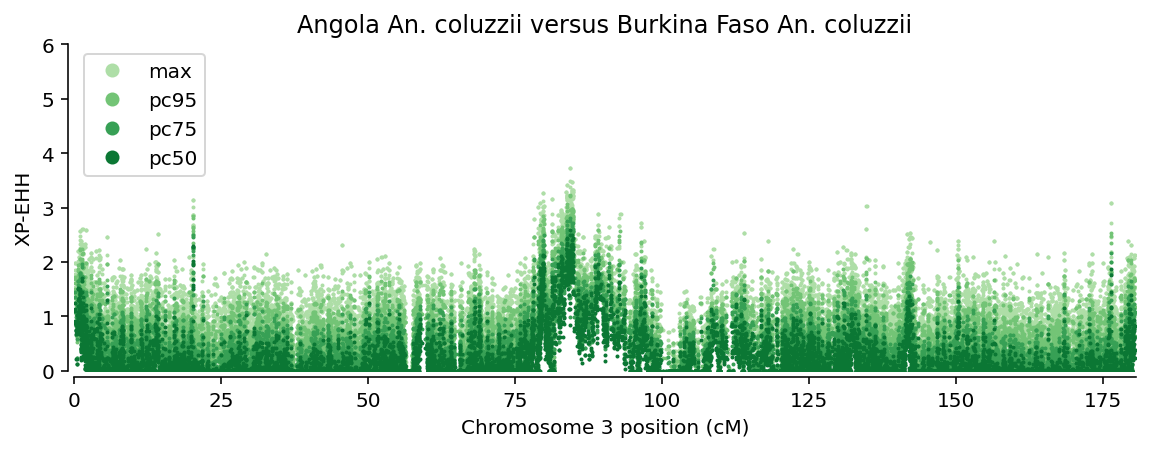

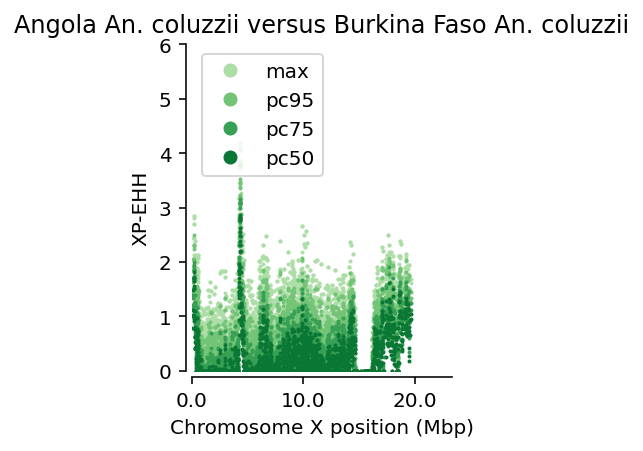

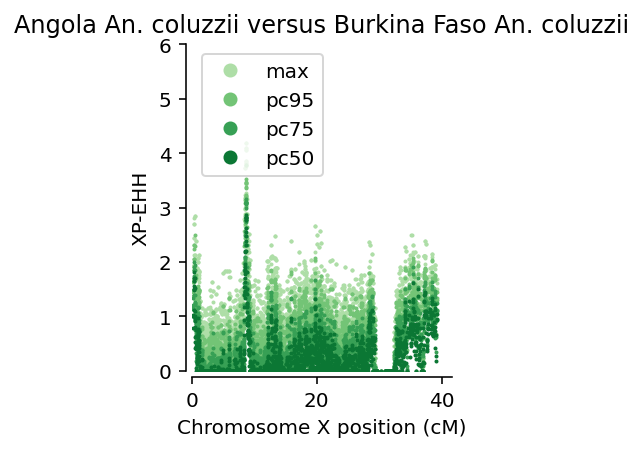

In [ ]:
for pop1, pop2 in pop_pairs:
    for chromosome in '2', '3', 'X':
        run_xpehh(pop1, pop2, chromosome)

In [ ]:
print(xpehh_root.tree())

In [9]:
zarr.consolidate_metadata(xpehh_root.store)

<zarr.hierarchy.Group '/'>